In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
hawaii_weather = automap_base()

# reflect the tables
hawaii_weather.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
print (hawaii_weather.classes.keys())

['measurement', 'station']


In [8]:
# Save references to each table
measurement = hawaii_weather.classes.measurement
station = hawaii_weather.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

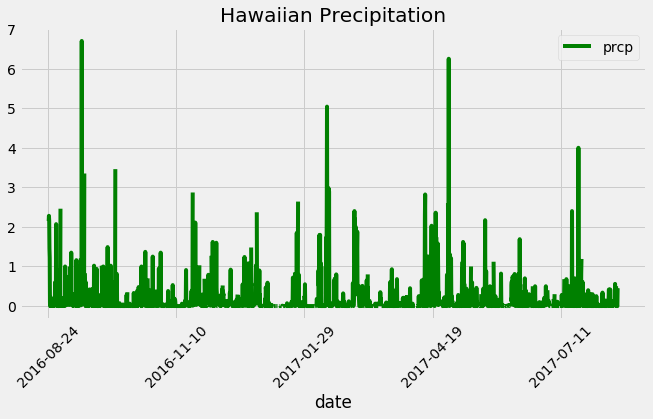

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(func.max(measurement.date)).first()[0]
last_date = dt.datetime.strptime(last_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
prev_year = last_date - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date,measurement.prcp).filter(measurement.date>=prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
hawaii_df = pd.DataFrame(results).set_index("date")

# Sort the dataframe by date
hawaii_df = hawaii_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_df.plot(rot = 45, figsize = (10,5), color = "green")
plt.title("Hawaiian Precipitation")
plt.savefig("Precipitation.png") 
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
hi_stations = session.query(station).count()
hi_stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
select = [func.min(measurement.tobs),
         func.max(measurement.tobs),
         func.avg(measurement.tobs)]

select_query = session.query(*select).filter(measurement.station == "USC00519281").all()
select_query

[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

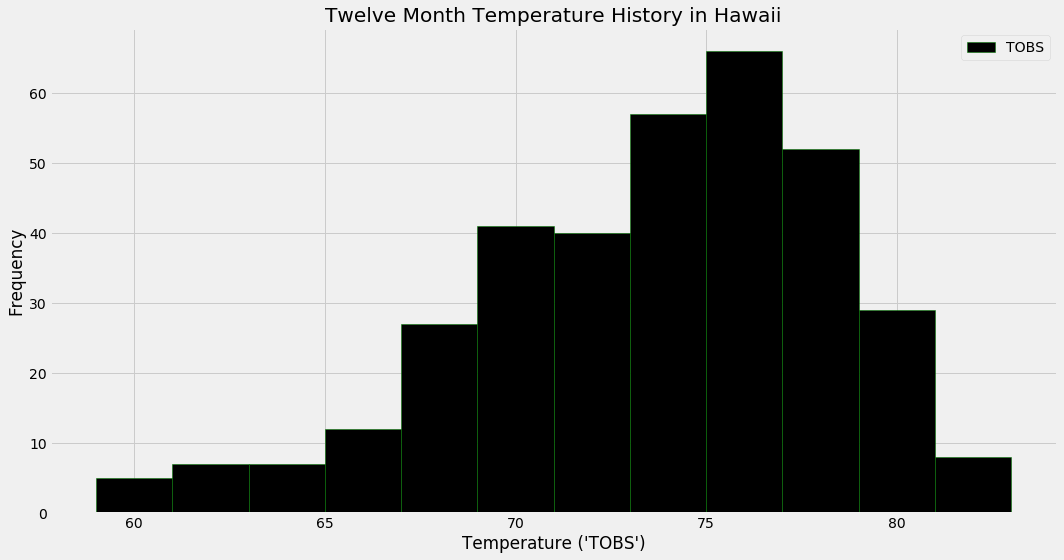

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.tobs).filter(measurement.date >=prev_year).\
            filter(measurement.station == "USC00519281").\
            order_by(measurement.date).all()
temp_df = pd.DataFrame(temp_data, columns=["TOBS"])

from matplotlib import colors

temp_df.plot.hist(bins = 12, color = "Black", ec="Green", title = "Twelve Month Temperature History in Hawaii")
plt.gcf().set_size_inches(15, 8)
plt.xlabel("Temperature ('TOBS')")
plt.legend(loc = "upper right")
plt.tight_layout()
plt.show






## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
end_dt = dt.date(2012, 2, 28)
last_year = end_dt - dt.timedelta(days = 365)

print(calc_temps(last_year, end_dt))


[(56.0, 72.76152158010241, 86.0)]


<function matplotlib.pyplot.show(*args, **kw)>

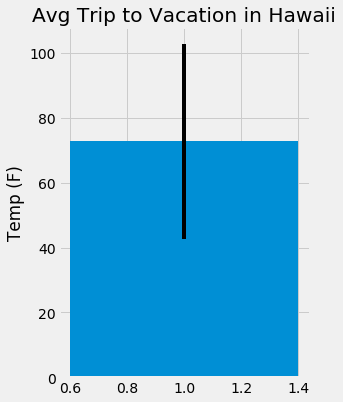

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_min = 56.0
temp_max = 86.0
temp_avg = 72.76152158010241
temp_diff = temp_max - temp_min

plt. figure (figsize = (4, 6))
plt. tick_params (bottom = "off", top = "off", labelbottom = "off")
plt.bar(1, temp_avg, yerr=temp_diff)
plt.ylabel ("Temp (F)")
plt.title ("Avg Vacation Temp in Hawaii")
plt.show

In [42]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [measurement.station, station.name, station.latitude, station.longitude, station.elevation, 
           measurement.prcp]
    
    return session.query(*sel).filter(measurement.station == station.station).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.station).order_by(measurement.prcp.desc()).all()

print(precipitation('2012-02-28','2012-03-05'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.05), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.03), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, None)]


In [33]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [64]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = "2012-02-28"
end_date = "2012-03-05"

# Use the start and end date to create a range of dates
dates = session.query(measurement.date).filter(measurement.date >= start_date).filter(measurement.date <= end_date).group_by(measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]
    
# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(measurement.tobs),
                       func.avg(measurement.tobs),
                       func.max(measurement.tobs)).filter(func.strftime("%m-%d", measurement.date) >= start_month_day).filter(func.strftime("%m-%d", measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", measurement.date)).all()]

# Setting daily normals to the fist index and pri
daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 2/28/2012 to 3/5/2012")
daily_normals


Aggregate Daily Normals for 2/28/2012 to 3/5/2012


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [62]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index



In [61]:
# Plot the daily normals as an area plot with `stacked=False`
